# Titanic Survival Part 2: Machine Learning Predictions in Python

In [1]:
# import modules
import numpy as np 
import pandas as pd 
import os
import re 

# load datasets
training_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

In [2]:
# separate target from predictors in training set
survived_labels = training_data['Survived'].copy()
train = training_data.drop('Survived', axis=1)

In [3]:
# create Title
def extract_title(name):
    """Given a name from the Name column, extract the title. 
    If it is common return it, else return 'Rare'.
    """
    try:
        title = re.search(r',\s(.+?)\.', name).groups()[0]
    except:
        title = ''
    
    if title in ["Mr", "Mrs", "Miss"]:
        return(title)
    else:
        return('Rare')
        
train['Title'] = train['Name'].map(lambda x: extract_title(x))

In [4]:
# Create NameLength
train['NameLength'] = train['Name'].map(lambda x: len(x))

In [5]:
# Create NumRelatives
train['NumRelatives'] = train['SibSp'] + train['Parch']

In [6]:
# Create FarePerPerson
train['count'] = 1
group = train[['Ticket','Fare','count']].groupby('Ticket').sum()
group['Fare'] = group['Fare']/group['count']
group['FarePerPerson'] = (group['Fare'])/group['count']

def map_fare_perperson(ticket):
    """Counts people per tickets and divides the fare per number of people in a ticket.
    Uses the group helper table with aggregated results.
    """

    row_names=np.array(list(group.index.values))
    loc=np.where(row_names == ticket)[0][0]
    
    return(group['FarePerPerson'][loc:loc+1][0])

train['FarePerPerson'] = train['Ticket'].map(lambda x: map_fare_perperson(x))

In [7]:
# Create Deck 
def clean_cabin(x):
    """Extract the Deck information, first letter only, 
    Limit to six groups, A through F, binning other decks to F.
    """
    
    letter=x[0]
    
    if letter not in 'ABCDEF':
        letter='F'
        
    return(letter)
    
train['Deck']=train['Cabin'].map(lambda x: clean_cabin(x), na_action='ignore')

In [8]:
# Embarked
# impute two missing with majority class
train['Embarked']=train['Embarked'].fillna('S')

In [9]:
# Age
# impute with group medians given gender, passenger class, and title
train['Age'] = train.groupby(['Sex', 'Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))

## Binary Indicators:

In [10]:
# Sex
train['IsMale'] = pd.get_dummies(train['Sex'])['male']

In [11]:
# Embarked
train['Embarked_S']=pd.get_dummies(train['Embarked'])['S']
train['Embarked_Q']=pd.get_dummies(train['Embarked'])['Q']

In [12]:
# Title
train['Title_Mr']=pd.get_dummies(train['Title'])['Mr']
train['Title_Mrs']=pd.get_dummies(train['Title'])['Mrs']
train['Title_Miss']=pd.get_dummies(train['Title'])['Miss']

In [13]:
# Pclass
train['Pclass_1']=pd.get_dummies(train['Pclass'])[1]
train['Pclass_2']=pd.get_dummies(train['Pclass'])[2]

In [14]:
# Deck
train['Deck'].fillna('None') # create a None category for NA values
train['Deck_A']=pd.get_dummies(train['Deck'])['A']
train['Deck_B']=pd.get_dummies(train['Deck'])['B']
train['Deck_C']=pd.get_dummies(train['Deck'])['C']
train['Deck_D']=pd.get_dummies(train['Deck'])['D']
train['Deck_E']=pd.get_dummies(train['Deck'])['E']
train['Deck_F']=pd.get_dummies(train['Deck'])['F']

In [15]:
# drop unwanted, redundant columns
train.drop(['PassengerId', 'Pclass','Name','Sex','SibSp','Parch','Ticket','Fare',
            'Cabin','count','Embarked','Title','Deck'], axis=1, inplace=True)

## Scaling

In [16]:
# scale Age, NameLength, NumRelatives, FarePerPerson
def minmax_scale(X):
    
    def scale(X, x):
        return((x - min(X)) / (max(X) - min(X)))
        
    return(X.map(lambda x: scale(X, x)))

def std_scale(X):

    def scale(X, x):
        return((x - np.mean(X)) / np.std(X))

    return(X.map(lambda x: scale(X, x)))
    
    
train['Age_minmax'] = minmax_scale(train['Age'])
train['Age_std'] = std_scale(train['Age'])
train['NameLength_minmax'] = minmax_scale(train['NameLength'])
train['NameLength_std'] = std_scale(train['NameLength'])
train['NumRelatives_minmax'] = minmax_scale(train['NumRelatives'])
train['NumRelatives_std'] = std_scale(train['NumRelatives'])
train['FarePerPerson_minmax'] = minmax_scale(train['FarePerPerson'])
train['FarePerPerson_std'] = std_scale(train['FarePerPerson'])

In [17]:
# comparing min-max and standard scaling
%matplotlib inline

from matplotlib import pyplot as plt

def plot_all(x, std_x, mm_x, y, std_y, mm_y, title):
    
    plt.figure(figsize=(14,8))

    plt.scatter(x,y, color='green', label='original scale', alpha=0.4)
    plt.scatter(std_x, std_y, color='red', label='standardized [$N(\mu=0, \; \sigma=1)$]', alpha=0.2)
    plt.scatter(mm_x, mm_y, color='blue', label='min-max scaled [min=0, max=1]', alpha=0.2)
    
    plt.title(title)
    plt.xlabel(title.split('and')[0]) 
    plt.ylabel(title.split('and')[1])
    plt.legend(loc='upper right')
    plt.tight_layout()

def plot_scaled(x, std_x, mm_x, y, std_y, mm_y, title):
    
    plt.figure(figsize=(5,5))

    plt.scatter(std_x, std_y, color='red', label='standardized [$N(\mu=0, \; \sigma=1)$]', alpha=0.2)
    plt.scatter(mm_x, mm_y, color='blue', label='min-max scaled [min=0, max=1]', alpha=0.2)
    
    plt.title(title)
    plt.xlabel(title.split('and')[0]) 
    plt.ylabel(title.split('and')[1])
    plt.legend(loc='upper right')
    plt.tight_layout()

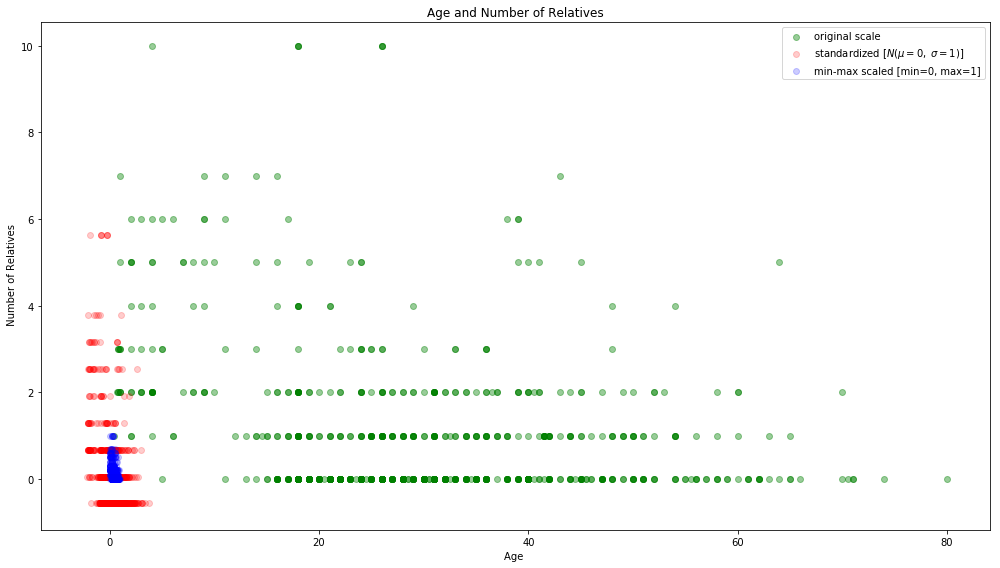

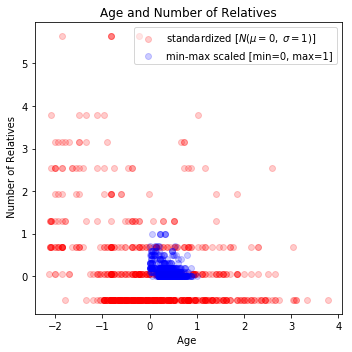

In [18]:
plot_all(train['Age'],train['Age_std'],train['Age_minmax'],
         train['NumRelatives'],train['NumRelatives_std'],train['NumRelatives_minmax'],
        'Age and Number of Relatives')

plt.show()

plot_scaled(train['Age'],train['Age_std'],train['Age_minmax'],
         train['NumRelatives'],train['NumRelatives_std'],train['NumRelatives_minmax'],
        'Age and Number of Relatives')

plt.show()

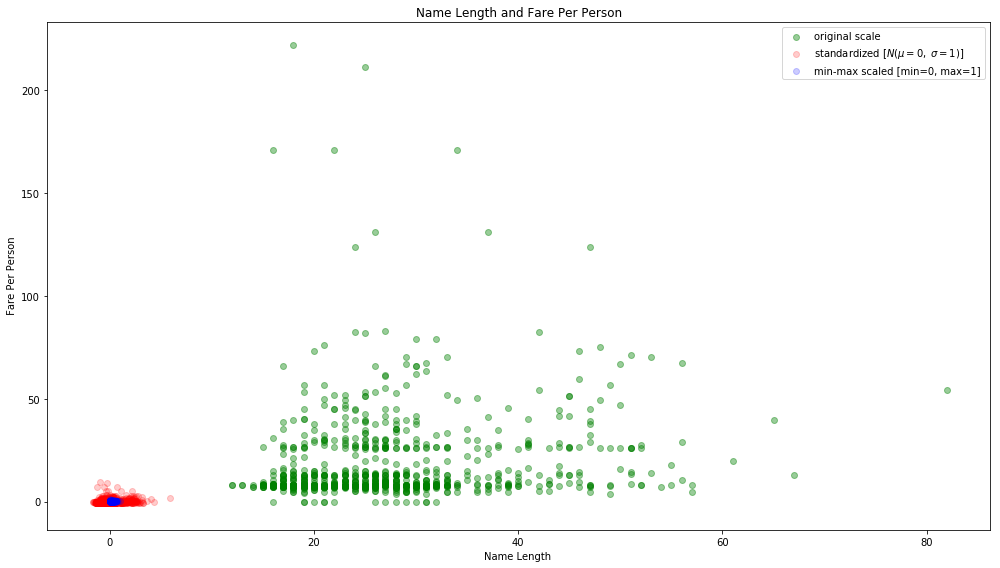

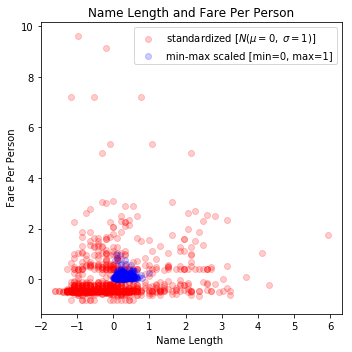

In [19]:
plot_all(train['NameLength'],train['NameLength_std'],train['NameLength_minmax'],
         train['FarePerPerson'],train['FarePerPerson_std'],train['FarePerPerson_minmax'],
        'Name Length and Fare Per Person')

plt.show()

plot_scaled(train['NameLength'],train['NameLength_std'],train['NameLength_minmax'],
         train['FarePerPerson'],train['FarePerPerson_std'],train['FarePerPerson_minmax'],
        'Name Length and Fare Per Person')

plt.show()

In [20]:
# drop unscaled and standard scaled features
train.drop(['Age', 'NameLength','FarePerPerson','NumRelatives','Age_std',
            'NameLength_std','FarePerPerson_std','NumRelatives_std'], axis=1, inplace=True)

In [21]:
train.head()

,IsMale,Embarked_S,Embarked_Q,Title_Mr,Title_Mrs,Title_Miss,Pclass_1,Pclass_2,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Age_minmax,NameLength_minmax,NumRelatives_minmax,FarePerPerson_minmax
0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0.271174,0.157143,0.1,0.032690
1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0.472229,0.557143,0.1,0.321416
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.321438,0.142857,0.0,0.035734
3,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0.434531,0.457143,0.1,0.119714
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0.434531,0.171429,0.0,0.036297


In [22]:
# convert to numpy arrays
train_processed = train.to_numpy()
train_labels = survived_labels.to_numpy()

## Training Models

First we train a few baseline models and compare their performances without hyperparameter tuning. After selecting the top 2-3 algorithms we proceed to tune them.


### Stochastic Gradient Descent

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

# using first 80% of the training set
train_subset = train_processed[:700]
labels_subset = train_labels[:700]

# training first model
sgd_clf.fit(train_subset, labels_subset)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
def predict_SGD(data, labels):
    """Make predictions using our SGD classifier and print the accuracy
    """
    
    predictions = sgd_clf.predict(data)
    results = pd.DataFrame({'preds': predictions,
                            'labels':labels})

    results['accurate'] = 0
    for i in range(0, len(results)):
        if results['labels'][i:i+1].values == results['preds'][i:i+1].values:
            results['accurate'][i:i+1] = 1
        else:
            pass
    
    accuracy = round(sum(results['accurate'])/results.shape[0],4)
    
    print('number of rows: ' +str(results.shape[0]))
    print('number of accurate predictions: ' +str(sum(results['accurate'])))
    print('accuracy: ' +str(accuracy))

In [25]:
# predict on the validation subset (remaining 20%)
validation_data = train_processed[700:]
validation_labels = training_data[700:]['Survived']

predict_SGD(validation_data, validation_labels)

number of rows: 191
number of accurate predictions: 154
accuracy: 0.8063


In [26]:
# predict on original 80% of training for comparison
original_data = train_processed[:700]
original_labels = training_data[:700]['Survived']

predict_SGD(original_data, original_labels)

number of rows: 700
number of accurate predictions: 553
accuracy: 0.79


The accuracy of the predictions on the original 80% of the training set, the data used to train the SGD classifier, seem slightly worse. One would expect the opposite. Let's run more predictions just to get a feel for the variance (instability of predictions) of this SGD model.

In [27]:
# using random shuffling
from sklearn.utils import shuffle

X, y = train_processed, train_labels

np.random.seed(43)
shuffled_data, shuffled_labels = shuffle(X, y)

shuffled_data_80pct = shuffled_data[:700]
shuffled_labels_80pct = shuffled_labels[:700]

# train model on first 80 % of the data
sgd_clf.fit(shuffled_data_80pct, shuffled_labels_80pct)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
# predict on the validation subset (remaining 20%)
shuffled_data_20pct = shuffled_data[700:]
shuffled_labels_20pct = shuffled_labels[700:]

predict_SGD(shuffled_data_20pct, shuffled_labels_20pct)

number of rows: 191
number of accurate predictions: 164
accuracy: 0.8586


In [29]:
predict_SGD(shuffled_data_80pct, shuffled_labels_80pct)

number of rows: 700
number of accurate predictions: 573
accuracy: 0.8186


This resulst makes even less sense, the data it was trained on was harder to predict by a 4% drop in accuracy. Will this be true more often than not? What if we trained and predicted on 100 random models.

In [30]:
def predict_SGD_val_train(data_v, labels_v, data_t, labels_t):
    """Make predictions for validation and training data using our SGD classifier.
    Compute the difference between validation and training accuracies.
    """
    
    preds_v = sgd_clf.predict(data_v)
    preds_t = sgd_clf.predict(data_t)
    
    v = pd.DataFrame({'preds': preds_v,
                      'labels':labels_v})
    t = pd.DataFrame({'preds': preds_t,
                      'labels':labels_t})
    v['accurate'] = 0
    for i in range(0, len(v)):
        if v['labels'][i:i+1].values == v['preds'][i:i+1].values:
            v['accurate'][i:i+1] = 1
        else:
            pass
    
    t['accurate'] = 0
    for i in range(0, len(t)):
        if t['labels'][i:i+1].values == t['preds'][i:i+1].values:
            t['accurate'][i:i+1] = 1
        else:
            pass
        
    accuracy_v = round(sum(v['accurate'])/v.shape[0],4)
    accuracy_t = round(sum(t['accurate'])/t.shape[0],4)
       
    diff = accuracy_v - accuracy_t
    
    return(diff)  

In [31]:
# train SGD model on 100 randomly shuffled datasets
differences = []
for i in range(0,100):
    
    # random shuffle
    np.random.seed(i)
    shuffled_data, shuffled_labels = shuffle(X, y)

    # 80% for training
    shuffled_data_80pct = shuffled_data[:700]
    shuffled_labels_80pct = shuffled_labels[:700]
    
    # 20 % for validation
    shuffled_data_20pct = shuffled_data[700:]
    shuffled_labels_20pct = shuffled_labels[700:]

    # train
    sgd_clf.fit(shuffled_data_80pct, shuffled_labels_80pct)
    
    # predict
    res = predict_SGD_val_train(shuffled_data_20pct, shuffled_labels_20pct, 
                                shuffled_data_80pct, shuffled_labels_80pct)
    
    differences.append(res)

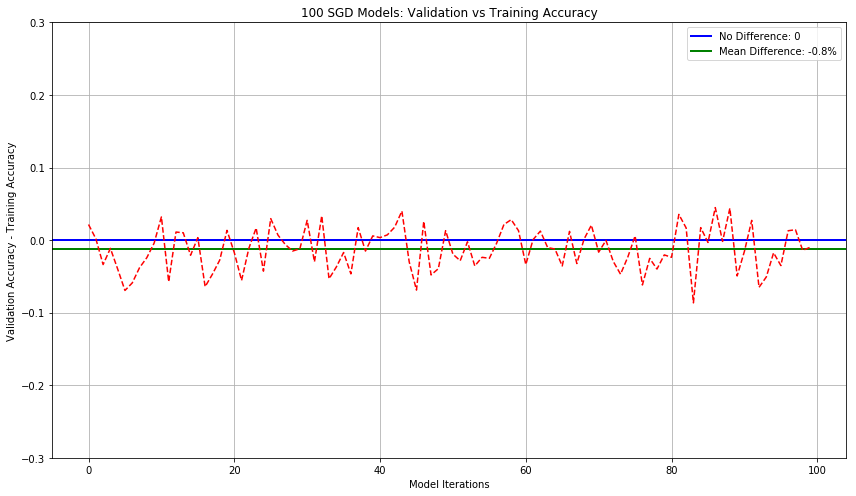

In [32]:
def plot_diff(x):

    plt.figure(figsize=(12,7))
    plt.ylim(-.3,.3)
    plt.axhline(y=0, linewidth=2, label='No Difference: 0', color='blue')
    plt.axhline(y=np.mean(differences), linewidth=2, label='Mean Difference: -0.8%', color='green')
    plt.title('100 SGD Models: Validation vs Training Accuracy')
    plt.xlabel('Model Iterations')
    plt.ylabel('Validation Accuracy - Training Accuracy')
    plt.legend(loc='upper right')
    plt.grid()
    plt.plot(x, 'r--')
    plt.tight_layout()

plot_diff(differences)
plt.show()

We see that on average the validation accuracy is very slightly lower than the training accuracy, so the difference is negligible, and the SGD model performs more or less equally on training and validation using the full training data.

This could be an indication that this algorithm is biased and there isn't enough flexibility in the model for it to learn, given our data. A look at learning curves will help determine what is going on.

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=127)
    train_acc, val_acc, train_mean, val_mean = [], [], [], []
    
    for m in range(5, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        val_acc.append(accuracy_score(y_val, y_val_predict))
        train_mean.append(np.mean(train_acc))
        val_mean.append(np.mean(val_acc))

    plt.figure(figsize=(18,10))
    plt.plot(np.sqrt(train_acc), 'r--', linewidth=.8, label="train accuracy")
    plt.plot(np.sqrt(val_acc), 'b--', linewidth=.8, label="validation accuracy")
    plt.plot(train_mean, 'r-', linewidth=1, label="mean train accuracy")
    plt.plot(val_mean, 'b-', linewidth=1, label="mean validation accuracy")
 
    plt.title("SGD Learning Rate During Training and Valudation")
    plt.axis([0, 710, 0.5, 1.1])
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)

<Figure size 1296x720 with 0 Axes>

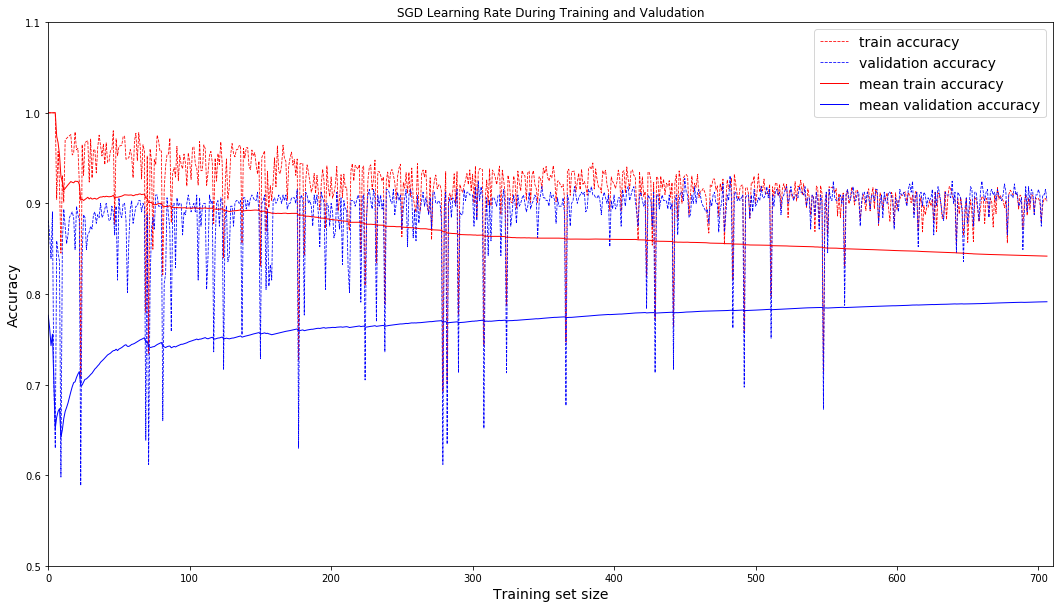

In [60]:
sgd_clf = SGDClassifier(random_state=42)
plt.figure(figsize=(18,10))
plot_learning_curves(sgd_clf, X, y)
plt.show()

The Stochastic Gradient Descent algorithm, because of its random approach, behaves fairly inconsistently for most of the training set. The mean train accuracy decreases as the algorithm learns and the mean validation accuracy increases, as expected. 

There is an early indication that the inconsistency (fluctuations) of this algorithm is settling down, but we need more data. Since we do not have more data, we need to find an algorithm that behaves more consistently. It also looks like the validation accuracy tops out at about 0.8.